In [1]:
import numpy as np
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageOps

### Data

In [2]:
path= './data/chest_xray/'

train_NORMAL = os.path.join(path, 'train/NORMAL')
train_PNEUMONIA = os.path.join(path, 'train/PNEUMONIA')
test_NORMAL = os.path.join(path, 'test/NORMAL')
test_PNEUMONIA = os.path.join(path, 'test/PNEUMONIA')
val_NORMAL = os.path.join(path, 'val/NORMAL')
val_PNEUMONIA = os.path.join(path, 'val/PNEUMONIA')
train_NORMAL_DIR = [os.path.join(train_NORMAL, x) for x in os.listdir(train_NORMAL)]
train_PNEUMONIA_DIR = [os.path.join(train_PNEUMONIA, x) for x in os.listdir(train_PNEUMONIA)]
test_NORMAL_DIR = [os.path.join(test_NORMAL, x) for x in os.listdir(test_NORMAL)]
test_PNEUMONIA_DIR = [os.path.join(test_PNEUMONIA, x) for x in os.listdir(test_PNEUMONIA)]
val_NORMAL_DIR = [os.path.join(val_NORMAL, x) for x in os.listdir(val_NORMAL)]
val_PNEUMONIA_DIR = [os.path.join(val_PNEUMONIA, x) for x in os.listdir(val_PNEUMONIA)]
dataset = {
    "train_NORMAL":train_NORMAL_DIR,
    "train_PNEUMONIA":train_PNEUMONIA_DIR,
    "test_NORMAL":test_NORMAL_DIR,
    "test_PNEUMONIA":test_PNEUMONIA_DIR,
    "val_NORMAL":val_NORMAL_DIR,
    "val_PNEUMONIA":val_PNEUMONIA_DIR
    }

### Visual

In [3]:
#Normal pic 
rand_pic_normal = random.choice(train_NORMAL_DIR)
rand_pic_normal

'./data/chest_xray/train/NORMAL\\NORMAL2-IM-1190-0001.jpeg'

In [4]:
#Pneumonia
rand_pic_pneum = random.choice(train_PNEUMONIA_DIR)
rand_pic_pneum

'./data/chest_xray/train/PNEUMONIA\\person48_bacteria_233.jpeg'

Text(0.5, 1.0, 'Pneumonia')

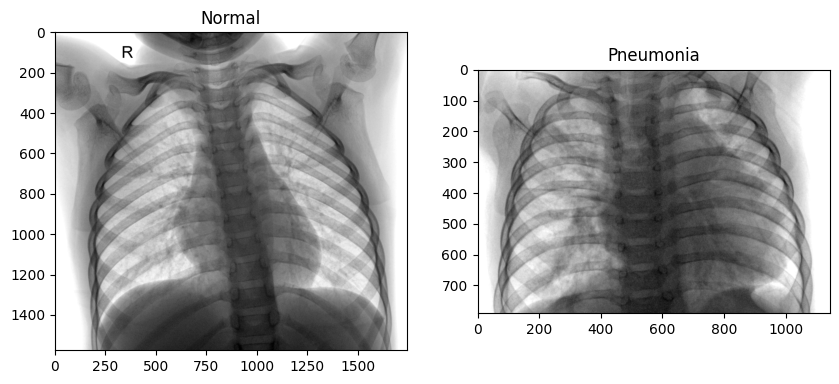

In [5]:
#Let's plot these images
f = plt.figure(figsize= (10,6))

a1 = f.add_subplot(1,2,1)
plt.imshow(ImageOps.invert(Image.open(rand_pic_normal).convert('L')), cmap='gray')
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
plt.imshow(ImageOps.invert(Image.open(rand_pic_pneum).convert('L')), cmap='gray')
a2.set_title('Pneumonia')

In [6]:
def show_image(path: list, dataset:str, label:str, num_pics=2):
  # Routine to plot the images
  if num_pics > 1:
    fig, ax = plt.subplots(1, num_pics, sharex=True)
    plt.tight_layout()
    ax = ax.ravel()
    for idx, pth in enumerate(path[:num_pics]):
      ax[idx].imshow(plt.imread(pth), cmap='gray')
    fig.suptitle('Dataset: {}, Label: {}'.format(dataset, label))
  elif num_pics == 1:
    plt.imshow(plt.imread(path[:num_pics][0]), cmap='gray')
    plt.title('Dataset: {}, Label: {}'.format(dataset, label))
    plt.figure()

def visualize_dataset_distribution(dataset: dict, x_label: str, y_label: str, title: str):
  # Routine to visualize the per class distribution of the dataset
  folders = list(dataset.keys())
  folders_vals = list(map(lambda x: len(dataset[x]), folders))
  folders_paths = ['_'.join(x.split("/")[-2:]) for x in folders]
  for idx, f in enumerate(folders_paths):
    print('{}: contains {} images'.format(folders_paths[idx], folders_vals[idx]))
  plt.bar(folders_paths, folders_vals, width = 0.5, color = 'blue', align = 'center', edgecolor = 'black')
  plt.xticks(rotation=70)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title("Distribution of images in the dataset")
  plt.show()

def plot_confusion_matrix_self(cm, classes, title, cmap):
  plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)
  fmt = 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
  plt.ylabel(ylabel = 'True label', labelpad = 25)
  plt.xlabel(xlabel = 'Predicted label', labelpad = 25)
  plt.show()

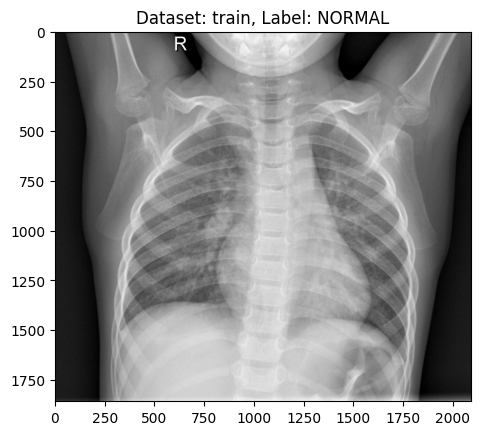

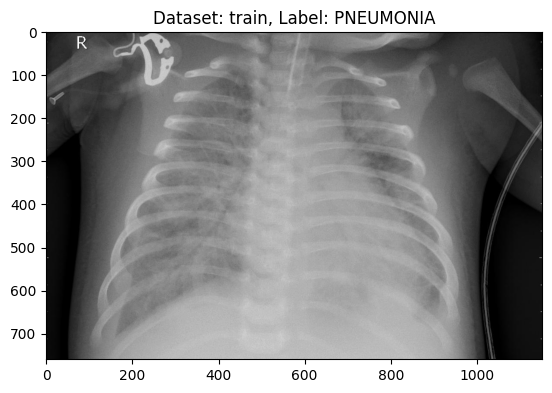

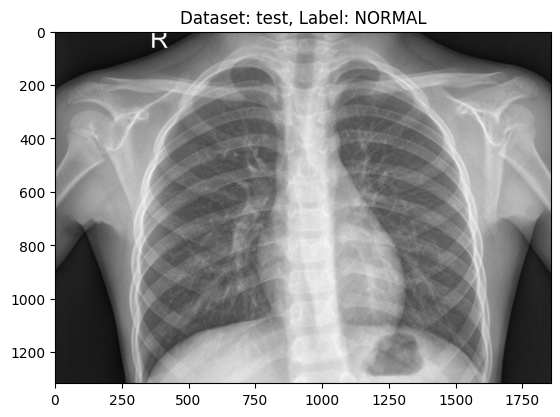

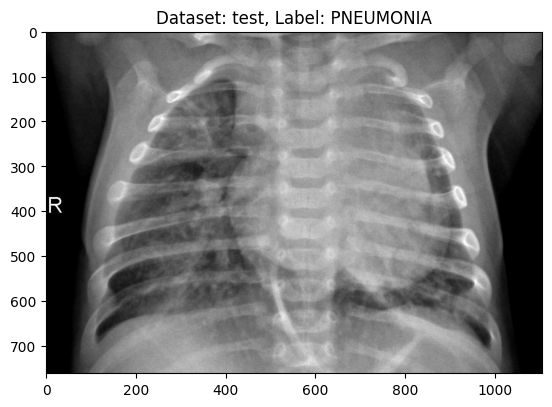

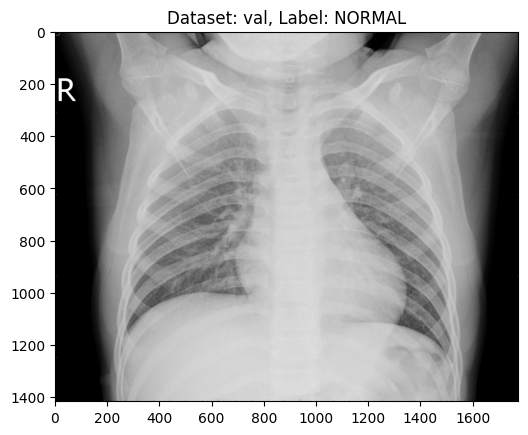

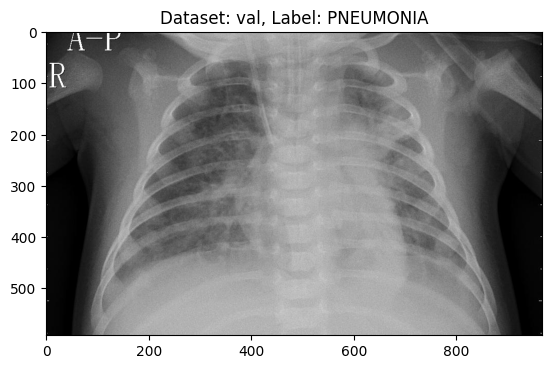

<Figure size 640x480 with 0 Axes>

In [7]:
# Visualizing the first num_pics image in the train, test and val datasets 
show_image(dataset["train_NORMAL"], num_pics=1, dataset="train", label="NORMAL")
show_image(dataset["train_PNEUMONIA"], num_pics=1, dataset="train", label="PNEUMONIA")

show_image(dataset["test_NORMAL"], num_pics=1, dataset="test", label="NORMAL")
show_image(dataset["test_PNEUMONIA"], num_pics=1, dataset="test", label="PNEUMONIA")

show_image(dataset["val_NORMAL"], num_pics=1, dataset="val", label="NORMAL")
show_image(dataset["val_PNEUMONIA"], num_pics=1, dataset="val", label="PNEUMONIA")

train_NORMAL: contains 1341 images
train_PNEUMONIA: contains 3875 images
test_NORMAL: contains 234 images
test_PNEUMONIA: contains 390 images
val_NORMAL: contains 8 images
val_PNEUMONIA: contains 8 images


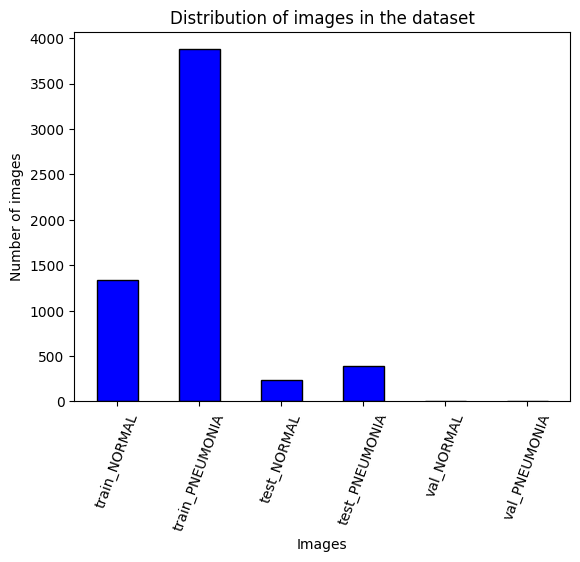

In [8]:
# Visualizing the datasets
x_label = "Images"
y_label = "Number of images"
title = "Distribution of images in the dataset"
visualize_dataset_distribution(dataset=dataset, x_label=x_label, y_label=y_label, title=title)

### Preprocess

In [9]:
# Function to preprocess and save images
def preprocess_and_save_images(source_dir, target_dir, target_size=(128, 128)):
    datagen = ImageDataGenerator(rescale=1./255)
    
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'PNEUMONIA'), exist_ok=True)
    
    # Create a generator for the source directory
    generator = datagen.flow_from_directory(
        source_dir,
        target_size=target_size,
        batch_size=1,  # Process one image at a time
        class_mode=None,  # Only data, no labels
        shuffle=False  # Keep the same order
    )

    for i in range(len(generator)):
        # Get the image and file path from the generator
        image = generator[i][0] * 255  # Revert rescale to original scale
        image = image.astype(np.uint8)
        
        # Get the corresponding file path and label from the generator
        original_filepath = generator.filepaths[i]
        label = 'NORMAL' if generator.labels[i] == 0 else 'PNEUMONIA'
        filename = os.path.basename(original_filepath)
        
        # Construct the target file path
        target_filepath = os.path.join(target_dir, label, filename)
        
        # Check if the file already exists in the target directory
        if os.path.exists(target_filepath):
            continue
        
        # Convert to PIL Image and save
        img = Image.fromarray(image)
        img.save(target_filepath)
        
    print(f"Saved processed images to {target_dir}")

In [10]:
path_pr = './data/preporcessed'

preprocess_and_save_images(f'{path}train/', f'{path_pr}/train/')
preprocess_and_save_images(f'{path}val/', f'{path_pr}/val/')
preprocess_and_save_images(f'{path}test/', f'{path_pr}/test/')


Found 5216 images belonging to 2 classes.
Saved processed images to ./data/preporcessed/train/
Found 16 images belonging to 2 classes.
Saved processed images to ./data/preporcessed/val/
Found 624 images belonging to 2 classes.
Saved processed images to ./data/preporcessed/test/


###  Модель IVGG13

In [11]:
def create_ivgg13_model():
    model = Sequential([
        Input(shape=(128, 128, 3)),

        # Conv 1 : 128*128*32
        Conv2D(32, (3, 3), activation='relu', padding='same'),

        # Conv 2 : 128*128*32
        Conv2D(32, (3, 3), activation='relu', padding='same'),

        # Pool 1: 64*64*32
        MaxPooling2D((2, 2)),

        # Conv 3 : 64*64*32
        Conv2D(32, (3, 3), activation='relu', padding='same'),

        # Conv 4 : 64*64*32
        Conv2D(32, (3, 3), activation='relu', padding='same'),

        # Pool 2 : 32*32*32
        MaxPooling2D((2, 2)),

        # Conv 5 : 32*32*64
        Conv2D(64, (3, 3), activation='relu', padding='same'),

        # Conv 6 : 32*32*64
        Conv2D(64, (3, 3), activation='relu', padding='same'),

        # Pool 3 : 16*16*64
        MaxPooling2D((2, 2)),

        # Conv 7 : 16*16*128
        Conv2D(128, (3, 3), activation='relu', padding='same'),

        # Conv 8 : 16*16*128
        Conv2D(128, (3, 3), activation='relu', padding='same'),

        # Pool 4 : 8*8*128
        MaxPooling2D((2, 2)),

        # Conv 9 : 8*8*64
        Conv2D(64, (3, 3), activation='relu', padding='same'),

        # Conv 10 : 8*8*64
        Conv2D(64, (3, 3), activation='relu', padding='same'),

        # Pool 5 : 4*4*64
        MaxPooling2D((2, 2)),

        # Flatten : 1024
        Flatten(),

        # FC14 Dense : 1024
        Dense(1024, activation='relu'),

        # FC15 Dense : 1024
        Dense(1024, activation='relu'),

        # FC16: 2 classes (sigmoid for binary classification)
        Dense(1, activation='sigmoid')
    ])

    return model

In [12]:
# Создаем модель
model = create_ivgg13_model()

# Компилируем модель
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Augmentation

In [13]:
# Создаем генератор для аугментации данных
datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=2,
    width_shift_range=0.005,
    height_shift_range=0.005,
    shear_range=0.005,
    zoom_range=0.005,
    vertical_flip=False,
    fill_mode='nearest',
    horizontal_flip = True
)

train_pr_dir = f'{path_pr}/train/'

# Определяем папку для NORMAL в тренировочном наборе
train_normal_dir = os.path.join(train_pr_dir, 'NORMAL')

normal_images = os.listdir(train_normal_dir)

# Применяем аугментацию и сохраняем изображения
for img_name in tqdm(normal_images, desc='Augmenting and saving images'):
    img_path = os.path.join(train_normal_dir, img_name)
    img = load_img(img_path)  # Загружаем изображение
    x = img_to_array(img)  # Преобразуем изображение в массив numpy
    x = x.reshape((1,) + x.shape)  # Решейпим для генератора
    i = 0
    for batch in datagen_aug.flow(x, batch_size=1, save_to_dir=train_normal_dir, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i >= 2:  # Применяем аугментацию к каждому изображению 2 раза
            break

Augmenting and saving images: 100%|██████████| 1341/1341 [00:10<00:00, 131.19it/s]


In [14]:
# Подсчитываем количество изображений в каждой папке
num_train_normal = len(os.listdir(train_normal_dir))
num_train_pneumonia = len(os.listdir(os.path.join(train_pr_dir, 'PNEUMONIA')))

# Выводим количество изображений в каждом классе
print(f"Train NORMAL: {num_train_normal} images")
print(f"Train PNEUMONIA: {num_train_pneumonia} images")

Train NORMAL: 3698 images
Train PNEUMONIA: 3875 images


### Генераторы данных

In [15]:
# Создаем генераторы данных
def create_generators(train_dir, val_dir, test_dir, target_size=(128, 128), batch_size=32):
        
    datagen = ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        #classes=['NORMAL', 'PNEUMONIA']
    )

    validation_generator = datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        #classes=['NORMAL', 'PNEUMONIA']
    )

    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        #classes=['NORMAL', 'PNEUMONIA'],
        #shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [16]:
# Получаем генераторы данных
train_generator, validation_generator, test_generator = create_generators(f'{path_pr}/train/', f'{path_pr}/val/', f'{path_pr}/test/')

Found 7573 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [17]:
# Обеспечение повторения данных для валидационного генератора
def repeat_validation_generator(generator):
    while True:
        for data in generator:
            yield data

In [18]:
# Расчет steps_per_epoch и validation_steps
steps_per_epoch_train = train_generator.samples // train_generator.batch_size

print(f"steps_per_epoch_train: {steps_per_epoch_train}")

steps_per_epoch_train: 236


In [19]:
# Обучаем модель
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_train
)

Epoch 1/5


C:\Users\grayni\Desktop\tr_py\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


237/237 ━━━━━━━━━━━━━━━━━━━━ 80s 324ms/step - accuracy: 0.5104 - loss: 0.7009 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/5


C:\Python3121\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


237/237 ━━━━━━━━━━━━━━━━━━━━ 75s 318ms/step - accuracy: 0.5085 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 73s 306ms/step - accuracy: 0.5137 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 73s 306ms/step - accuracy: 0.5093 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 73s 309ms/step - accuracy: 0.5177 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6934


In [20]:
# Получаем предсказания модели для тестового набора данных
predictions = model.predict(test_generator)
predictions_binary = np.where(predictions > 0.5, 1, 0)

# Истинные метки классов для тестового набора данных
true_classes = test_generator.classes

# Вычисляем accuracy, precision, recall, F1 Score
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
precision = precision_score(true_classes, predictions_binary)
recall = recall_score(true_classes, predictions_binary)
f1 = f1_score(true_classes, predictions_binary)

print(f'Accuracy: {test_acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1: {f1}\n')

# Строим confusion matrix
cm = confusion_matrix(true_classes, predictions_binary)
print("Confusion Matrix:")
print(cm, '\n')

# Нормализованная confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:")
print(cm_normalized)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.6193 - loss: 0.6879
Accuracy: 0.625
Precision: 0.625
Recall: 1.0
f1: 0.7692307692307693

Confusion Matrix:
[[  0 234]
 [  0 390]] 

Normalized Confusion Matrix:
[[0. 1.]
 [0. 1.]]


Accuracy (Точность): 62.5%

Данная метрика показывает, что модель правильно классифицировала 62.5% всех примеров.
Precision (Прецизионность): 62.5%

Прецизионность показывает долю истинных положительных результатов среди всех примеров, которые модель классифицировала как положительные. Прецизионность модели 62.5%, что означает, что из всех положительных предсказаний модели 62.5% были правильными.
Recall (Полнота): 100%

Полнота показывает долю истинных положительных результатов среди всех реальных положительных примеров. В данном случае полнота модели 100%, что означает, что модель нашла все положительные примеры, но она также отнесла к положительным все отрицательные примеры.
F1 Score: 0.769

F1 Score является гармоническим средним прецизионности и полноты. В данном случае значение 0.769 указывает на баланс между прецизионностью и полнотой, но при этом прецизионность достаточно низкая по сравнению с полнотой.
Confusion Matrix (Матрица неточностей):

Матрица показывает, что модель не смогла правильно классифицировать ни один отрицательный пример (класс 0). Все 234 примера, которые должны были быть классифицированы как отрицательные, были классифицированы как положительные.
Все положительные примеры (класс 1) были правильно классифицированы, что и объясняет высокий показатель полноты.

### Model 2

In [21]:
def create_ivgg13_model2():
    model = Sequential([
        Input(shape=(128, 128, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(1024, activation='relu'),
        Dense(1, activation='sigmoid')  # два класса: NORMAL и PNEUMONIA
    ])
    
    return model

In [22]:
# Получаем генераторы данных
train_generator2, validation_generator2, test_generator2 = create_generators(f'{path_pr}/train/', f'{path_pr}/val/', f'{path_pr}/test/', batch_size=32)

Found 7573 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [23]:
from tensorflow.keras.optimizers import Adam

# Задаем learning rate
learning_rate = 0.001

# Создаем оптимизатор с заданным learning rate
optimizer = Adam(learning_rate=learning_rate)

model2 = create_ivgg13_model2()
model2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
# Обучаем модель
train_generator2.reset()
validation_generator2.reset()

history2 = model2.fit(
    train_generator2,
    epochs=10,
    validation_data=validation_generator2,
    validation_steps=16
)

Epoch 1/10


C:\Users\grayni\Desktop\tr_py\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


237/237 ━━━━━━━━━━━━━━━━━━━━ 87s 355ms/step - accuracy: 0.6934 - loss: 0.5187 - val_accuracy: 0.6250 - val_loss: 1.1541
Epoch 2/10


C:\Python3121\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


237/237 ━━━━━━━━━━━━━━━━━━━━ 100s 423ms/step - accuracy: 0.9519 - loss: 0.1272 - val_accuracy: 0.8125 - val_loss: 0.2162
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 94s 398ms/step - accuracy: 0.9729 - loss: 0.0754 - val_accuracy: 0.9375 - val_loss: 0.1319
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 101s 424ms/step - accuracy: 0.9772 - loss: 0.0603 - val_accuracy: 1.0000 - val_loss: 0.1420
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 91s 382ms/step - accuracy: 0.9829 - loss: 0.0429 - val_accuracy: 0.8125 - val_loss: 0.5581
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 87s 367ms/step - accuracy: 0.9832 - loss: 0.0478 - val_accuracy: 0.7500 - val_loss: 0.3631
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 93s 389ms/step - accuracy: 0.9820 - loss: 0.0517 - val_accuracy: 0.9375 - val_loss: 0.1527
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 102s 432ms/step - accuracy: 0.9833 - loss: 0.0409 - val_accuracy: 1.0000 - val_loss: 0.0738
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 95s 400ms/step - accuracy: 0.9892 - loss: 0.0330 - 

In [25]:
# Получаем предсказания модели для тестового набора данных
predictions2 = model2.predict(test_generator2)
predictions_binary2 = np.where(predictions2 > 0.5, 1, 0)

# Истинные метки классов для тестового набора данных
true_classes2 = test_generator2.classes

# Вычисляем accuracy, precision, recall, F1 Score
test_loss2, test_acc2 = model.evaluate(test_generator2, steps=test_generator2.samples // test_generator2.batch_size)
precision2 = precision_score(true_classes2, predictions_binary2)
recall2 = recall_score(true_classes2, predictions_binary2)
f12 = f1_score(true_classes2, predictions_binary2)

print(f'Accuracy: {test_acc2}')
print(f'Precision: {precision2}')
print(f'Recall: {recall2}')
print(f'f1: {f12}\n')

# Строим confusion matrix
cm2 = confusion_matrix(true_classes2, predictions_binary2)
print("Confusion Matrix:")
print(cm2, '\n')

# Нормализованная confusion matrix
cm_normalized2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:")
print(cm_normalized2)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.6234 - loss: 0.6877
Accuracy: 0.6266447305679321
Precision: 0.6189624329159212
Recall: 0.8871794871794871
f1: 0.7291886195995785

Confusion Matrix:
[[ 21 213]
 [ 44 346]] 

Normalized Confusion Matrix:
[[0.08974359 0.91025641]
 [0.11282051 0.88717949]]


Accuracy (Точность): 62.66%

Модель правильно классифицировала 62.66% всех примеров.
Precision (Прецизионность): 61.89%

Из всех предсказанных положительных случаев только 61.89% являются истинно положительными. Это значит, что модель часто ошибается, классифицируя отрицательные примеры как положительные.
Recall (Полнота): 88.72%

Полнота показывает, что модель нашла 88.72% всех реальных положительных примеров. Это высокий показатель, что говорит о том, что модель практически все положительные примеры классифицировала правильно, но при этом и немалое количество отрицательных примеров классифицировала как положительные.
F1 Score: 0.7292

F1 Score гармоническое среднее между прецизионностью и полнотой. Значение 0.7292 указывает на то, что, несмотря на относительно высокую полноту, прецизионность остается значительно ниже.
Confusion Matrix (Матрица неточностей):

Модель неправильно классифицировала 213 отрицательных примеров как положительные, что составляет 91.03% от всех отрицательных примеров.
Модель правильно классифицировала 346 положительных примеров, что составляет 88.72% от всех положительных примеров.
Модель неправильно классифицировала 44 положительных примеров как отрицательные.
Выводы
Перекос модели: Модель показывает перекос в сторону положительных предсказаний. Это подтверждается высоким показателем полноты и относительно низкой прецизионностью.

### Model 3

In [26]:
cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))

cnn_model.add(Conv2D(32, (3, 3), activation="relu"))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(activation = 'relu', units = 128))
cnn_model.add(Dense(activation = 'sigmoid', units = 1))

C:\Users\grayni\Desktop\tr_py\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [28]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

train_set = train_datagen.flow_from_directory(f'{path_pr}/train/',
                                              target_size = (128, 128),
                                              batch_size = 32,
                                              class_mode = 'binary')

test_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = test_datagen.flow_from_directory(f'{path_pr}/val/',
                                                        target_size=(128, 128),
                                                        batch_size=32,
                                                        class_mode='binary')

test_set = test_datagen.flow_from_directory(f'{path_pr}/test/',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 7573 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [29]:
cnn_model_his = cnn_model.fit(train_set,
                              steps_per_epoch = 163,
                              epochs = 10,
                              validation_data = validation_generator,
                              validation_steps = 624)

Epoch 1/10


C:\Users\grayni\Desktop\tr_py\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 188ms/step - accuracy: 0.6754 - loss: 0.7548 - val_accuracy: 0.8750 - val_loss: 0.2851
Epoch 2/10
  1/163 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.9375 - loss: 0.1029

C:\Python3121\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.8911 - loss: 0.2767 - val_accuracy: 0.6875 - val_loss: 0.8182
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 201ms/step - accuracy: 0.9015 - loss: 0.2472 - val_accuracy: 0.6250 - val_loss: 0.7520
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.9000 - loss: 0.2462 - val_accuracy: 0.8750 - val_loss: 0.3135
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.9177 - loss: 0.2105 - val_accuracy: 0.7500 - val_loss: 0.4335
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.9239 - loss: 0.2008 - val_accuracy: 0.8125 - val_loss: 0.3237
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 172ms/step - accuracy: 0.9317 - loss: 0.1841 - val_accuracy: 0.6250 - val_loss: 0.9195
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.9390 - loss: 0.1657 - val_accuracy: 0.6250 - val_loss: 0.9384
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 179ms/step - accuracy: 0.9240 - loss: 0.1938 - val_acc

In [30]:
# Получаем предсказания модели для тестового набора данных
predictions3 = cnn_model.predict(test_set)
predictions_binary3 = np.where(predictions3 > 0.5, 1, 0)

# Истинные метки классов для тестового набора данных
true_classes3 = test_set.classes

# Вычисляем accuracy, precision, recall, F1 Score
test_loss3, test_acc3 = cnn_model.evaluate(test_set, steps=test_set.samples // test_set.batch_size)
precision3 = precision_score(true_classes3, predictions_binary3)
recall3 = recall_score(true_classes3, predictions_binary3)
f13 = f1_score(true_classes3, predictions_binary3)

print(f'Accuracy: {test_acc3}')
print(f'Precision: {precision3}')
print(f'Recall: {recall3}')
print(f'f1: {f13}\n')

# Строим confusion matrix
cm3 = confusion_matrix(true_classes3, predictions_binary3)
print("Confusion Matrix:")
print(cm3, '\n')

# Нормализованная confusion matrix
cm_normalized3 = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:")
print(cm_normalized3)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8190 - loss: 0.5236
Accuracy: 0.8240131735801697
Precision: 0.6
Recall: 0.7615384615384615
f1: 0.6711864406779661

Confusion Matrix:
[[ 36 198]
 [ 93 297]] 

Normalized Confusion Matrix:
[[0.15384615 0.84615385]
 [0.23846154 0.76153846]]


Accuracy (Точность): 82.40%

Модель правильно классифицировала 82.40% всех примеров, что является хорошим показателем.
Precision (Прецизионность): 60%

Из всех предсказанных положительных случаев только 60% являются истинно положительными. Это значит, что модель довольно часто ошибается, классифицируя отрицательные примеры как положительные.
Recall (Полнота): 76.15%

Полнота показывает, что модель нашла 76.15% всех реальных положительных примеров. Это относительно высокий показатель, что говорит о том, что модель хорошо распознает положительные примеры, но при этом некоторое количество отрицательных примеров классифицируется как положительные.
F1 Score: 0.6712

F1 Score гармоническое среднее между прецизионностью и полнотой. Значение 0.6712 указывает на то, что модель имеет некоторую степень компромисса между полнотой и прецизионностью.
Confusion Matrix (Матрица неточностей):

Модель неправильно классифицировала 198 отрицательных примеров как положительные, что составляет 84.62% от всех отрицательных примеров.
Модель правильно классифицировала 297 положительных примеров, что составляет 76.15% от всех положительных примеров.
Модель неправильно классифицировала 93 положительных примеров как отрицательные.

### ROC

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_model1, tpr_model1, thresholds_model1 = roc_curve(test_generator.classes, predictions)
auc_model1 = roc_auc_score(test_generator.classes, predictions)

fpr_model2, tpr_model2, thresholds_model2 = roc_curve(test_generator2.classes, predictions2)
auc_model2 = roc_auc_score(test_generator2.classes, predictions2)

fpr_model3, tpr_model3, thresholds_model3 = roc_curve(test_set.classes, predictions3)
auc_model3 = roc_auc_score(test_set.classes, predictions3)

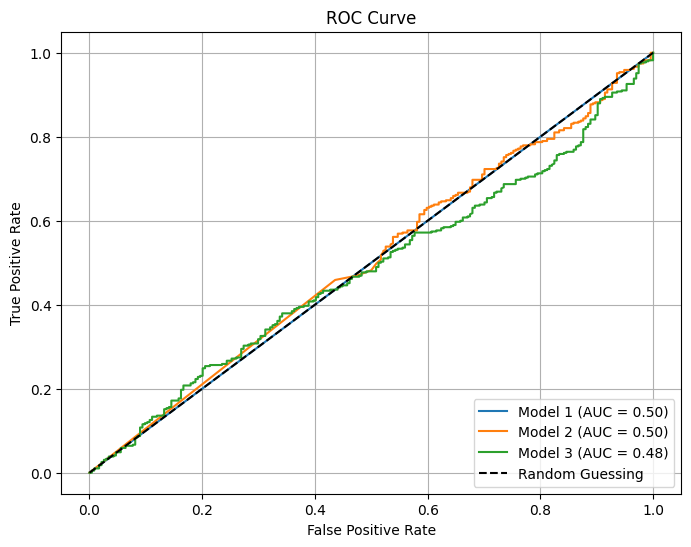

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_model1, tpr_model1, label=f'Model 1 (AUC = {auc_model1:.2f})')
plt.plot(fpr_model2, tpr_model2, label=f'Model 2 (AUC = {auc_model2:.2f})')
plt.plot(fpr_model3, tpr_model3, label=f'Model 3 (AUC = {auc_model3:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()